# Data Science Challenge

## Data Description
Column | Description
:---|:---
`id` | Record index
`timestamp` | Datetime (YYYY:MM:DD HH:MM:SS)
`country` | Current country of employment
`employment_status` | Employment status (Full time, Part time, Independent or freelancer)
`job_title` | Current job title of the candidate
`job_years` | No. of years working on the job
`is_manager` | Whether the candidate holds a managerial position or not (Yes or No)
`hours_per_week` | No. of hours per day committed to the current job
`telecommute_days_per_week` | No. of telecommuting days per week (working from home)
`education` | Highest degree in education the candidate has received
`is_education_computer_related` | Is the education related to the field of computer science (Yes or No)
`certifications` | Does the candidate have any relevant certifications (Yes or No)
`salary` | Monthly Salary (in US $$)

In [10]:
import numpy as np
import pandas as pd
from statistics import mean
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.utils import shuffle
from sklearn.model_selection import KFold

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

pd.set_option('display.max_columns', 101)

import warnings
warnings.filterwarnings('ignore')

In [11]:
class Data():
    def __init__(self):
        self.train = pd.read_csv('train.csv')
        self.test = pd.read_csv('test.csv')

In [12]:
class EDA(Data):
    def __init__(self):
        super().__init__()
        self.describe(self.train)
        self.simple_plot(self.train)
        self.range_plot(self.train)
        self.trend_plot(self.train)
        self.map_plot(self.train)
        
    def describe(self, train):
        print('Column Headers')
        print(train.columns)
        print()
        print('Description of the numerical values of the data')
        print(train.describe())
        print()
        print('Unique values for columns')
        print('Countries:')
        print(train.country.unique())
        print()
        print('Employment Status:')
        print(train.employment_status.unique())
        print()
        print('Job Titles:')
        print(train.job_title.unique())
        print()
        print('Education:')
        print(train.education.unique())
        print()
        
    def simple_plot(self, train):
        train['country'].value_counts().plot(kind='bar', figsize = (20, 10), rot = 90)
        plt.title('Country')
        simple_count = {
            'Emplyment Status': train['employment_status'].value_counts(),
            'Job Title': train['job_title'].value_counts(),
            'Manager': train['is_manager'].value_counts(),
            'Education': train['education'].value_counts(),
            'Computer Education': train['is_education_computer_related'].value_counts(),
            'Certifications': train['certifications'].value_counts(),
            'Telecommute Days per Week': train['telecommute_days_per_week'].value_counts()
        }
        figure, axis = plt.subplots(3, 3, figsize = (20, 10))
        for i, (title, data) in enumerate(simple_count.items()):
            axis[i // 3, i % 3].bar(data.index, data.values)
            axis[i // 3, i % 3].set_title(title)
            for tick in axis[i // 3, i % 3].get_xticklabels():
                tick.set_rotation(90)
        figure.delaxes(axis[2][1])
        figure.delaxes(axis[2][2])
        plt.subplots_adjust(top = 0.99, bottom = 0.01, hspace = 1.5, wspace = 0.4)
        plt.show()
    
    def range_plot(self, train):
        def data_range(data, breaks = 10):
            low, high = data.min(), data.max()
            x, y = np.linspace(low, high, num = breaks + 1), [0] * breaks
            for value in data.values:
                for i in range(len(x) - 1):
                    if (value >= x[i] and value < x[i + 1]): y[i] += 1
                if (value == high): y[-1] += 1
            return dict(zip(x, y))
        range_count = {
            'Job Year': data_range(train['job_years']),
            'Hours Per Week': data_range(train['hours_per_week']),
            'Salary': data_range(train['salary'])
        }
        figure, axis = plt.subplots(3, 1, figsize = (15, 10))
        for i, (title, data) in enumerate(range_count.items()):
            axis[i % 3].bar(data.keys(), data.values(), width = 300 if title == 'Salary' else 0.5)
            axis[i % 3].set_title(title)
        plt.subplots_adjust(hspace = 0.25)
        plt.show()
        
    def trend_plot(self, train):
        # date = mm/dd/yyyy
        trend_count = []
        yyyymmdd = defaultdict(list)
        for index, row in train.iterrows():
            mm, dd, yyyy = row['timestamp'].split(' ')[0].split('/')
            yyyymmdd[str(yyyy) + str(mm) + str(dd)].append(row['salary'])
        for key, value in yyyymmdd.items():
            trend_count.append([key, mean(value)])
        plt.plot(*zip(*trend_count))
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        plt.xlabel('Time')
        plt.ylabel('Salary')
        plt.title('Salary vs Time')
        plt.rcParams["figure.figsize"] = (15, 7)
        plt.show()
    
    def map_plot(self, train):
        def get_y(default_dict):
            np_array = np.array(list(default_dict.values()))
            return np_array.T.tolist()
            
        countries = list(train['country'].unique())
        num_employees_manager_country = defaultdict(list)
        education_country = defaultdict(list)
        
        for country in countries:
            row = train.loc[train['country'] == country]
            try:
                yes = row['is_manager'].value_counts()['Yes']
            except:
                yes = 0
            num_employees_manager_country[country] = [len(row), yes]
            
            education = row['education'].value_counts()
            try:
                phd = education['Doctorate/PhD']
            except:
                phd = 0
            try:
                masters = education['Masters']
            except:
                masters = 0
            try:
                bachelors = education['Bachelors (4 years)']
            except:
                bachelors = 0
            try:
                associates = education['Associates (2 years)']
            except:
                associates = 0
            try:
                none = education['None (no degree completed)']
            except:
                none = 0

            education_country[country] = [phd, masters, bachelors, associates, none]
        
        # plot
        x = np.arange(len(countries))
        
        width = 0.5
        fig, ax = plt.subplots()
        data = get_y(num_employees_manager_country)
        rects1 = ax.bar(x - width/2, data[0], width, label = 'Employees')
        rects2 = ax.bar(x + width/2, data[1], width, label = 'Managers')
        ax.set_ylabel('Employees')
        ax.set_title('Employees and managers by Country')
        ax.set_xticks(x, countries)
        ax.legend()
        fig.tight_layout()
        plt.show()
        
        width = 0.5
        fig, ax = plt.subplots()
        data = get_y(education_country)
        rects1 = ax.bar(x - width/4, data[0], width, label = 'pHd')
        rects2 = ax.bar(x - width/2, data[1], width, label = 'Masters')
        rects3 = ax.bar(x, data[2], width, label = 'Bachelors')
        rects4 = ax.bar(x + width/2, data[3], width, label = 'Associates')
        rects5 = ax.bar(x + width/4, data[4], width, label = 'None')
        
        ax.set_ylabel('Employees')
        ax.set_title('Education by Country')
        ax.set_xticks(x, countries)
        ax.legend()
        fig.tight_layout()
        plt.show()

        

Column Headers
Index(['id', 'timestamp', 'country', 'employment_status', 'job_title',
       'job_years', 'is_manager', 'hours_per_week',
       'telecommute_days_per_week', 'education',
       'is_education_computer_related', 'certifications', 'salary'],
      dtype='object')

Description of the numerical values of the data
               id    job_years  hours_per_week  telecommute_days_per_week  \
count  4277.00000  4277.000000     4260.000000                4266.000000   
mean   2139.00000     4.479514       40.859110                   1.034927   
std    1234.80788     1.990791        1.754911                   1.651160   
min       1.00000     0.000000       37.000000                   0.000000   
25%    1070.00000     3.407156       40.000000                   0.000000   
50%    2139.00000     4.640830       40.000000                   0.000000   
75%    3208.00000     5.000000       41.114138                   1.000000   
max    4277.00000    10.000000       45.000000           

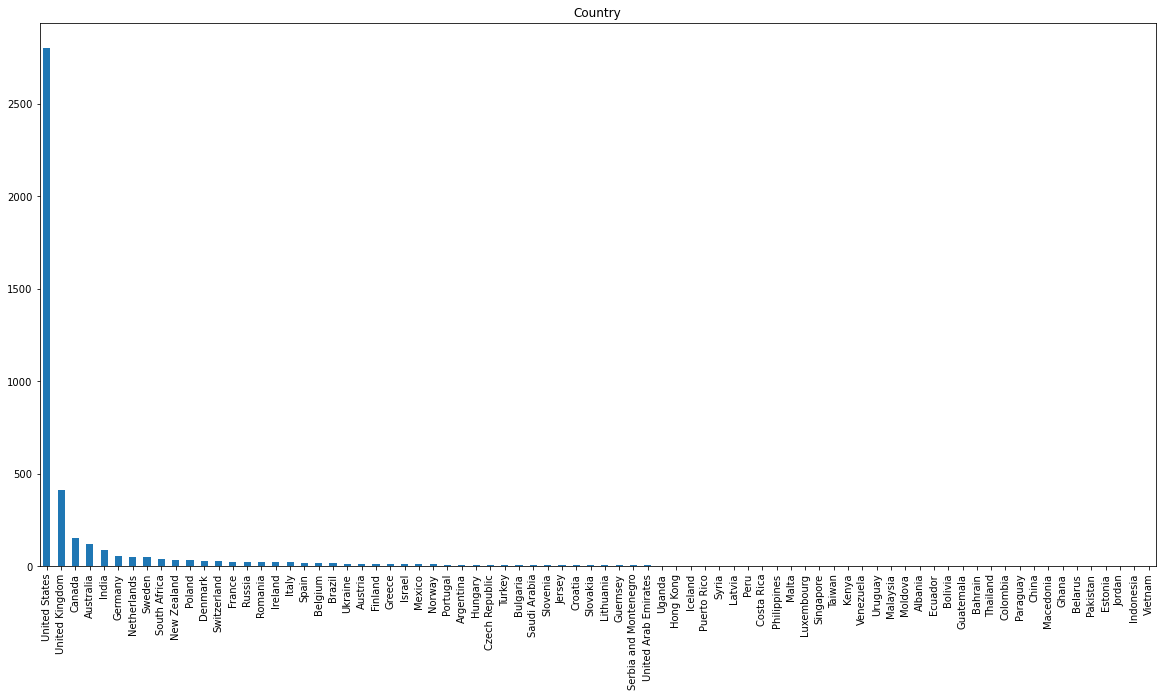

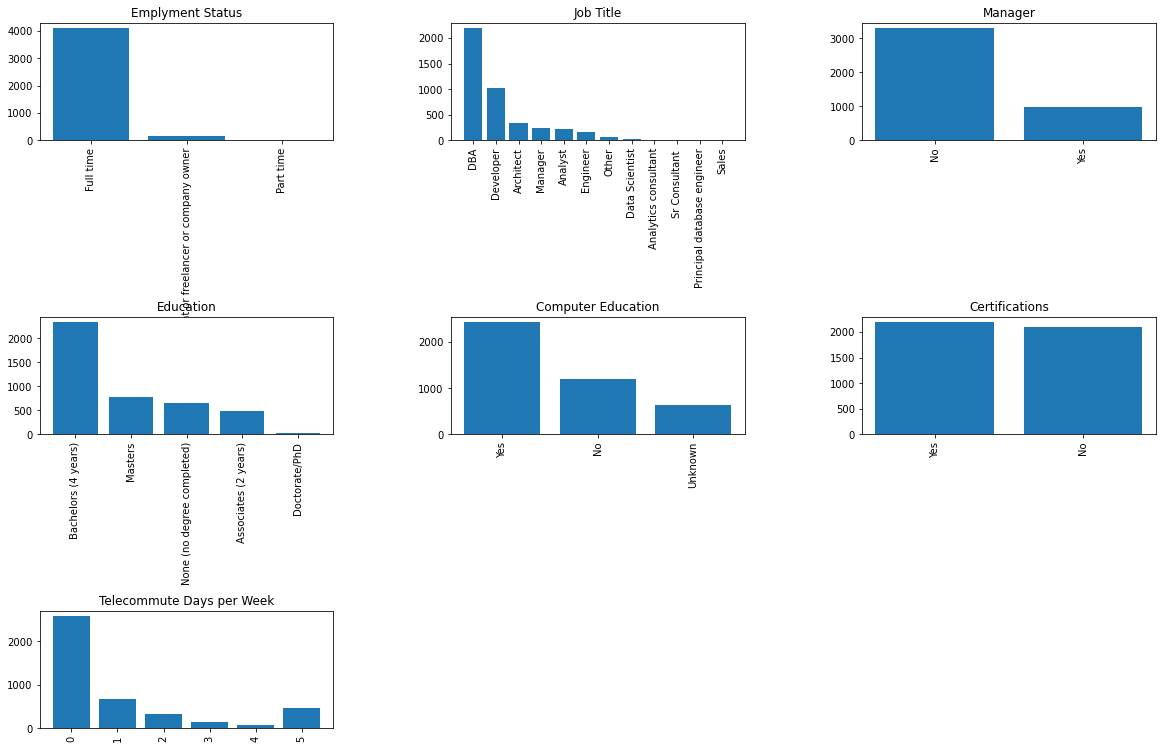

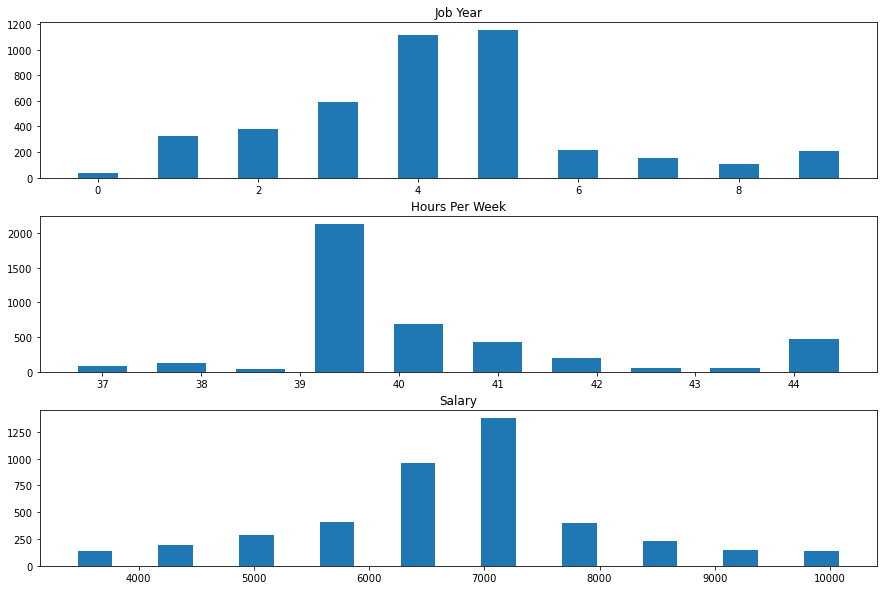

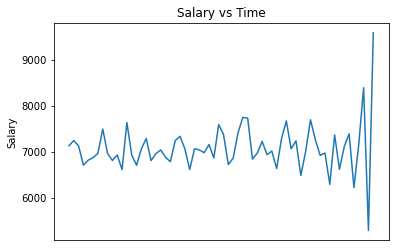

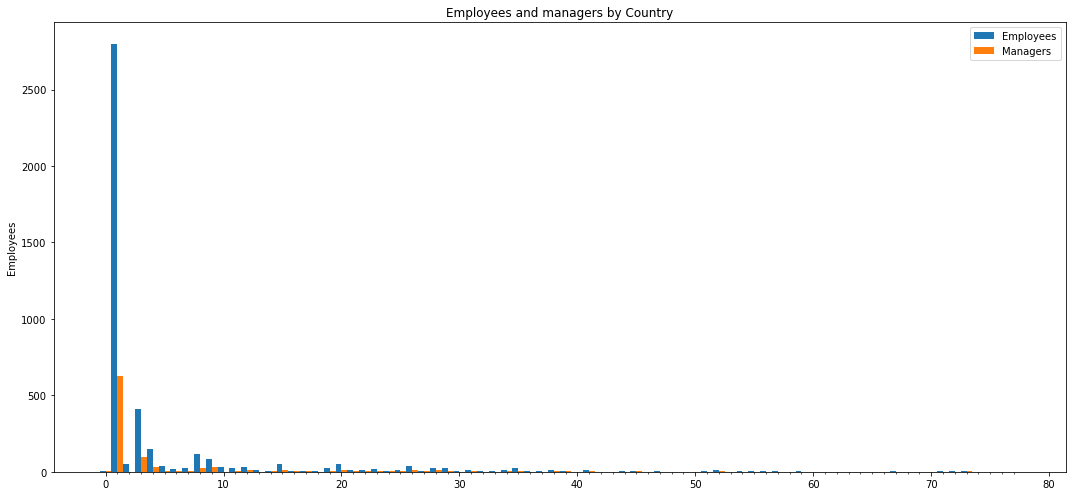

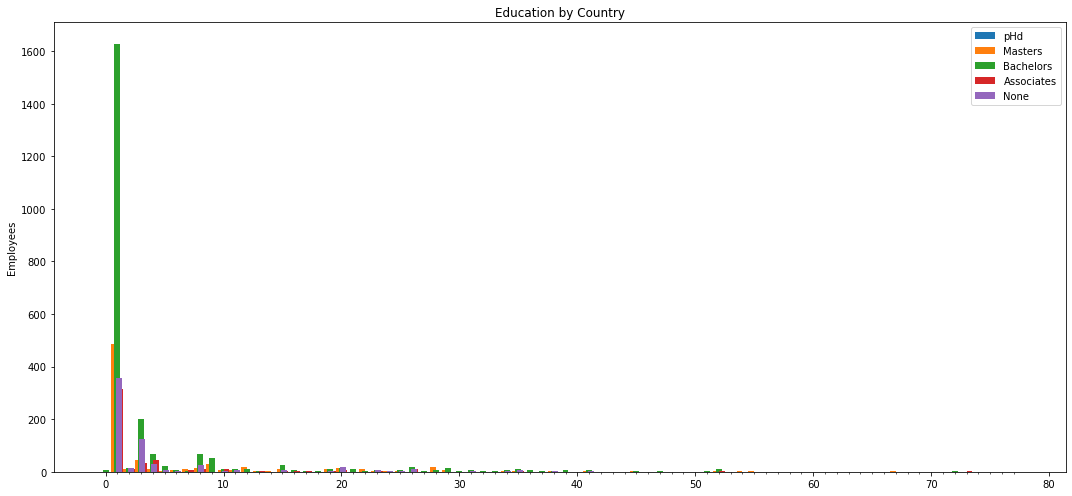

In [13]:
EDA()

In [14]:
class Modify_Data(Data):
    def __init__(self, original = False, only_train = True):
        self.only_train = only_train
        super().__init__()
        if (only_train):
            self.time(self.train)
            self.country(self.train)
            self.employment_status(self.train)
            self.job_title(self.train)
            self.education(self.train)
            self.boolean(self.train)
            self.save(self.train)
        else:
            self.time(self.test)
            self.country(self.test)
            self.employment_status(self.test)
            self.job_title(self.test)
            self.education(self.test)
            self.boolean(self.test)
            self.save(self.test)
    
    def time(self, df):
        yyyymm = {'year': [], 'month': []}
        for index, row in df.iterrows():
            mm, _, yyyy = row['timestamp'].split(' ')[0].split('/')
            yyyymm['year'].append(int(yyyy))
            yyyymm['month'].append(int(mm))
        df.insert(2, 'year', yyyymm['year'])
        df.insert(3, 'month', yyyymm['month'])
        if (self.only_train): self.train = df.drop('timestamp', 1)
        else: self.test = df.drop('timestamp', 1)
    
    def country(self, df):
        if (self.only_train): self.train = df.drop('country', 1)
        else: self.test = df.drop('country', 1)
    
    def employment_status(self, df):
        if (self.only_train): self.train = df.replace(['Full time', 'Independent or freelancer or company owner', 'Part time'], [2, 0, 1])
        else: self.test = df.replace(['Full time', 'Independent or freelancer or company owner', 'Part time'], [2, 0, 1])
    
    def job_title(self, df):
        if (self.only_train): self.train = df.replace(['Developer', 'DBA', 'Other', 
                                    'Data Scientist', 'Manager', 
                                    'Architect', 'Analyst', 'Engineer', 
                                    'Sales', 'Analytics consultant', 
                                    'Principal database engineer', 'Sr Consultant '], 
                                   [1, 2, 0,
                                    3, 4,
                                    5, 6, 7,
                                    8, 9,
                                    10, 11])
        else: self.test = df.replace(['Developer', 'DBA', 'Other', 
                                    'Data Scientist', 'Manager', 
                                    'Architect', 'Analyst', 'Engineer', 
                                    'Sales', 'Analytics consultant', 
                                    'Principal database engineer', 'Sr Consultant '], 
                                   [1, 2, 0,
                                    3, 4,
                                    5, 6, 7,
                                    8, 9,
                                    10, 11])
    
    def education(self, df):
        if (self.only_train): self.train = df.replace(['Bachelors (4 years)', 'Masters', 'Associates (2 years)',
                                    'None (no degree completed)', 'Doctorate/PhD'], [2, 3, 1, 0, 4])
        else: self.test = df.replace(['Bachelors (4 years)', 'Masters', 'Associates (2 years)',
                                    'None (no degree completed)', 'Doctorate/PhD'], [2, 3, 1, 0, 4])
        
    def boolean(self, df):
        if (self.only_train): self.train = df.replace(['Yes', 'No', 'Unknown'], [1, 0, 0])
        else: self.test = df.replace(['Yes', 'No', 'Unknown'], [1, 0, 0])
        
    def save(self, df):
        if (self.only_train):
            df.to_csv('train_updated.csv', index = False)
        else: df.to_csv('test_updated.csv', index = False)
        
        
        

In [15]:
# Modify_Data(only_train = True)
# Modify_Data(only_train = False)

In [16]:
class Train():
    def __init__(self):
        Modify_Data(only_train = True)
        self.train = pd.read_csv('train_updated.csv')
        self.models = [SVR(),  KNeighborsRegressor(), DecisionTreeRegressor(),
                       RandomForestRegressor(n_estimators = 1000), ExtraTreesRegressor(n_estimators = 1000)]
        X, y = self.get_data(self.train)
        self.select_trainer(X, y)
        model = self.train(X, y)
        self.predict(model)
                                                                                       
    
    def get_data(self, train):
        train = train.reset_index()
        data = shuffle(train.astype(float))
        X = data[['id', 'year', 'month', 'job_years', 'is_manager', 
                  'hours_per_week', 'telecommute_days_per_week', 'education',
                  'is_education_computer_related', 'certifications']]
        y = data[['salary']]
        return X, y
    
    def select_trainer(self, X, y):
        kf = KFold(n_splits = 10)
        for model in self.models:
            print(model)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                model.fit(X_train, y_train)
                yhat = model.predict(X_test)
                print(model.score(X_test, y_test))
            print()
    
    def train(self, X, y):
        model = self.models[-1]
        model.fit(X, y)
        return model
    
    def predict(self, model):
        Modify_Data(only_train = False)
        test = pd.read_csv('train_updated.csv')
        model.predict(test)
                                                                                       

In [17]:
Train()

SVR()


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').